In [ ]:
"""
Created By    : Josh Kern
Creation Date : 28 September 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose: This lab takes radiosonde observations and using a polar sterorographic projection, plots them using function 
fitting. To start, the code reads in data from the radiosonde observations text file. Next, the code creates our analysis
map with grid points using specified dimensions. Latitude and Longitude are converted using x,y coordinates and plotted on
analysis grid to verify. Next, our matrices are established. We need to get the analysis values at our grid points
with given radius of influences (10 cm, 20 cm), so we use a Gilchrest and Cressman approach using matrices to 
get these analysis values at grid points. The analysis values are then plotted for each radius of influence
on the analysis grid. The number of observations available are plotted as well. Lastly, 
the analysis values and number of observations are stored in text files.

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [3]:
!pip install pandas

     ---------------------------------------- 10.4/10.4 MB 1.4 MB/s eta 0:00:00


In [1]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as pd                #import pandas

In [2]:
### Read in observations ###

df = pd.read_csv("RAOBs_201903131200.txt", sep=",", names=["Station ID","Latitude", "Longitude", "500 mb Height (m)", "500 mb Wind Direction", "500 mb Wind Speed(knots)"])
df['rad.Longitude']= df['Longitude']*(np.pi/180)  #add a new column and convert to radians
df['rad.Latitude']= df['Latitude']*(np.pi/180)    #add a new column and convert to radians
heights_500mb= df['500 mb Height (m)']            #assign heights
df.head()                                         #show headers
                 

,Station ID,Latitude,Longitude,500 mb Height (m),500 mb Wind Direction,500 mb Wind Speed(knots),rad.Longitude,rad.Latitude
0,CWPL,51.47,-90.2,5460.0,285.0,29.0,-1.574287,0.898321
1,CWQI,43.83,-66.0,5540.0,325.0,41.0,-1.151917,0.764978
2,CWSE,53.55,-113.9,5360.0,280.0,12.0,-1.987930,0.934624
3,CYAH,53.75,-73.6,5340.0,300.0,70.0,-1.284562,0.938114
4,CYBK,64.30,-96.0,5220.0,95.0,17.0,-1.675516,1.122247


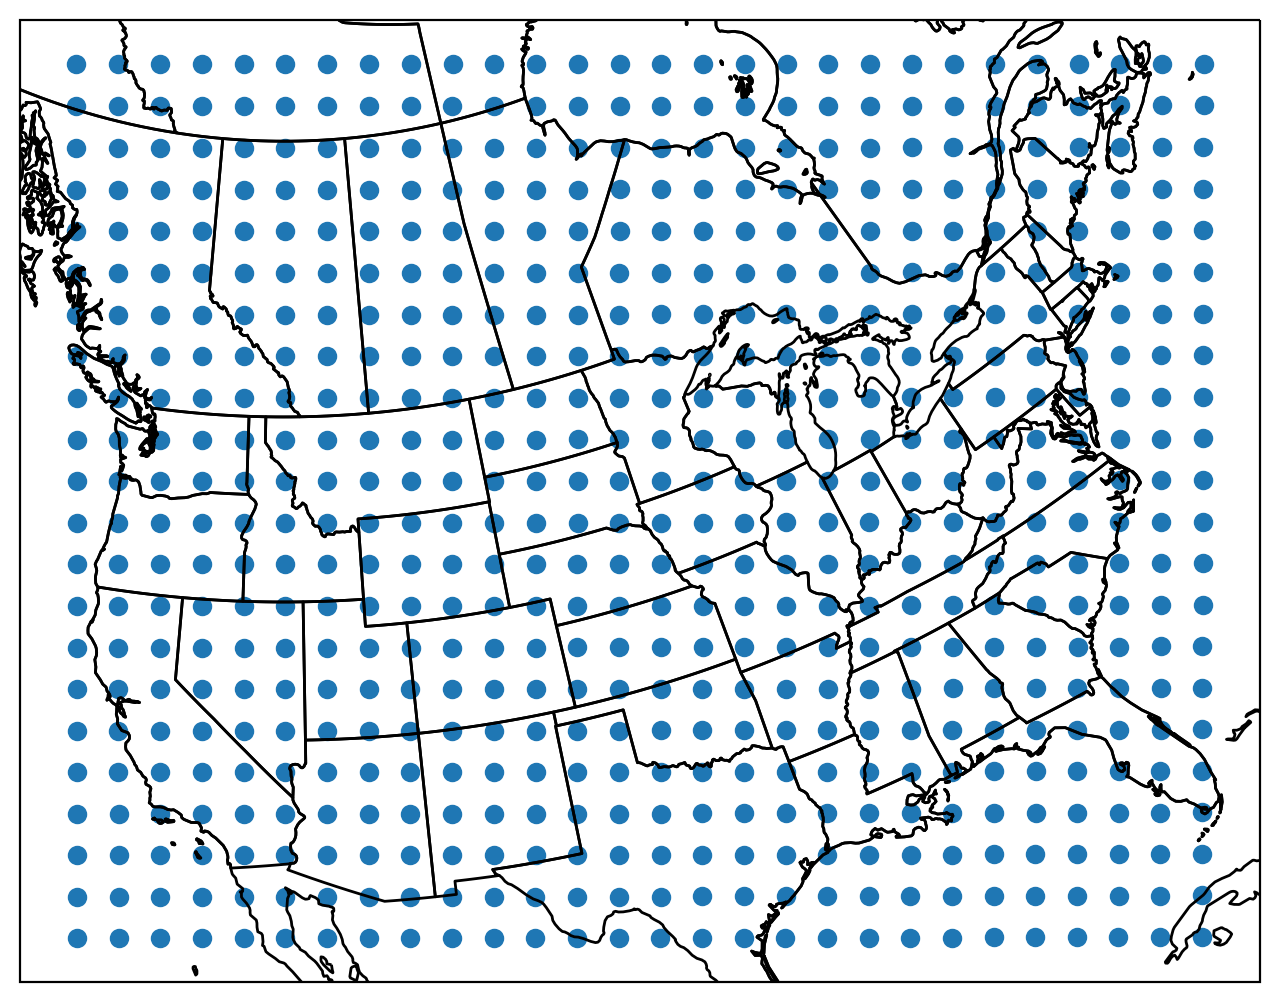

In [3]:
### Set up analysis map with a 22x28 rectangular grid of points ###
xstep = 18.9 + np.arange(22)*(1.27)                       #set x step
ystep = -6.3 + np.arange(28)*(1.27)                       #set y step
xx,yy = np.meshgrid(xstep, ystep)                        #set grid points

#set constants/variables
phi_latitude=60*(np.pi/180)
lambda_longitude =-115
radius_earth = 6371*1e5
map_scale= 1/(15e6)

x2lon = np.arctan(yy/xx) * (180/np.pi) + lambda_longitude
y2lat = (180/np.pi) * ((np.pi/2) - (2*np.arctan(np.sqrt((xx/map_scale)**2+(yy/map_scale)**2)/(radius_earth*(1+np.sin(phi_latitude))))))

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(x2lon.ravel(),y2lat.ravel(),transform=ccrs.PlateCarree())


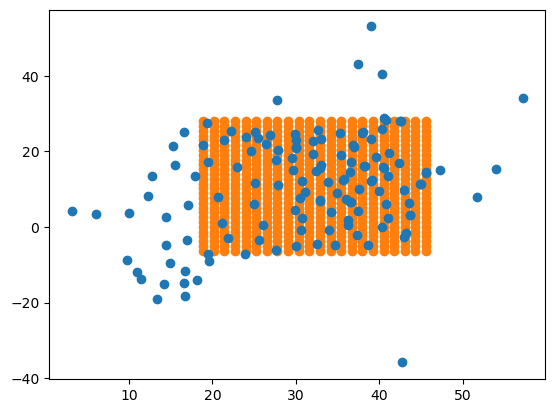

In [5]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
rlat = df['Latitude']
rlon = df['Longitude']

sigma = (1+ np.sin(phi_latitude))/(1+np.sin(rlat*(np.pi/180)))
r = radius_earth*sigma*(np.cos(rlat*(np.pi/180)))*map_scale
x_ob = r*np.cos((rlon*(np.pi/180))-(lambda_longitude*(np.pi/180)))
y_ob = r*np.sin((rlon*(np.pi/180))-(lambda_longitude*(np.pi/180)))

plt.scatter(x_ob, y_ob,zorder=10)
plt.scatter(xx.ravel(), yy.ravel())

In [6]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###

#Make matrices and vectors to get the analysis value at grid point with given roi's
radii_influences = np.array([10, 20])

#set grid dimensions
x_grid = 22                       
y_grid = 28

#establish observation adn analysis arrays
array_obs = np.empty((y_grid, x_grid, len(radii_influences)))
array_analysis = np.empty((y_grid, x_grid, len(radii_influences)))

#begin nested for loop
for num_radius_influence in range(len(radii_influences)):
    radius_influence = radii_influences[num_radius_influence]
    for i in range(len(xx[0])):
        for j in range(len(xx)):
            relative_x = xx[j, i] - x_ob
            relative_y = yy[j, i] - y_ob
            relative_rad = (relative_x**2 + relative_y**2)**0.5
            index_radinfs = np.where(relative_rad<radius_influence)[0]
            array_obs[j, i, num_radius_influence] = len(index_radinfs)
        
            fo = heights_500mb[index_radinfs].values
            x_n = relative_x[index_radinfs].values
            y_n = relative_y[index_radinfs].values     
            matrix1 = np.zeros((6,6))
            matrix2 = np.zeros(6)
        
            for k in range(len(x_n)):
                tp1 = np.matrix([[1, x_n[k], y_n[k], x_n[k]**2, y_n[k]**2, x_n[k]*y_n[k]]])
                tp2 = tp1.T * tp1
                matrix1 += tp2
                matrix2 += np.array([fo[k], x_n[k]*fo[k], y_n[k]*fo[k], x_n[k]**2 * fo[k], y_n[k]**2 * fo[k], x_n[k] * y_n[k] * fo[k]])
            
            #perform matrix calculations
            matrix1 = matrix1/(array_obs[j, i, num_radius_influence])
            matrix2 = matrix2/(array_obs[j, i, num_radius_influence])
            A = np.linalg.inv(matrix1) * np.matrix(matrix2).T
            array_analysis[j, i, num_radius_influence] = A[0,0]

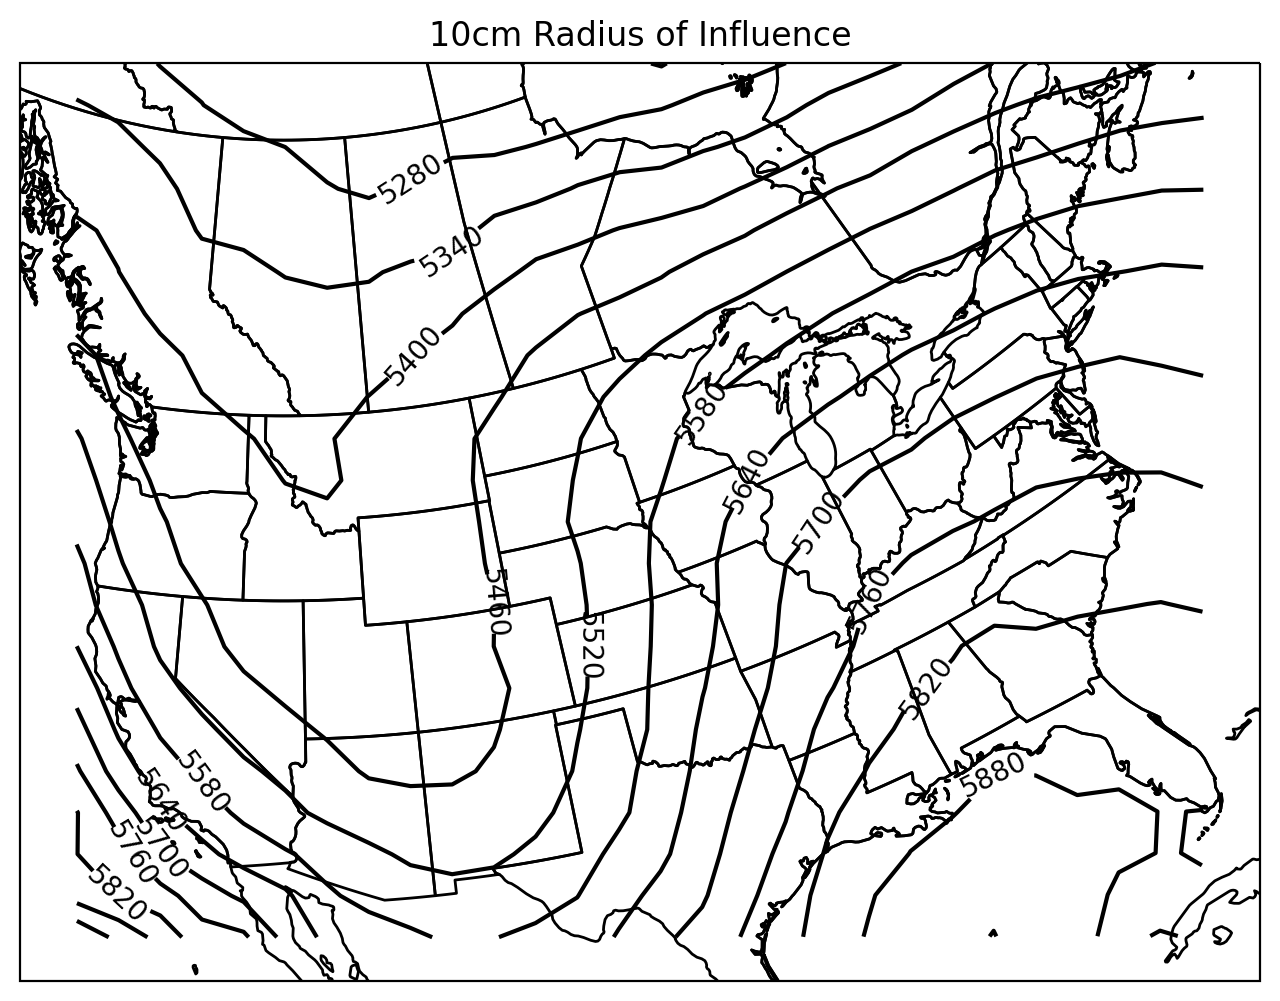

In [9]:
### Plot 500mb analyses over a map (10 cm ROI) ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(x2lon,y2lat,array_analysis[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('10cm Radius of Influence')
plt.savefig('10cm Radius of Influence')
plt.show()


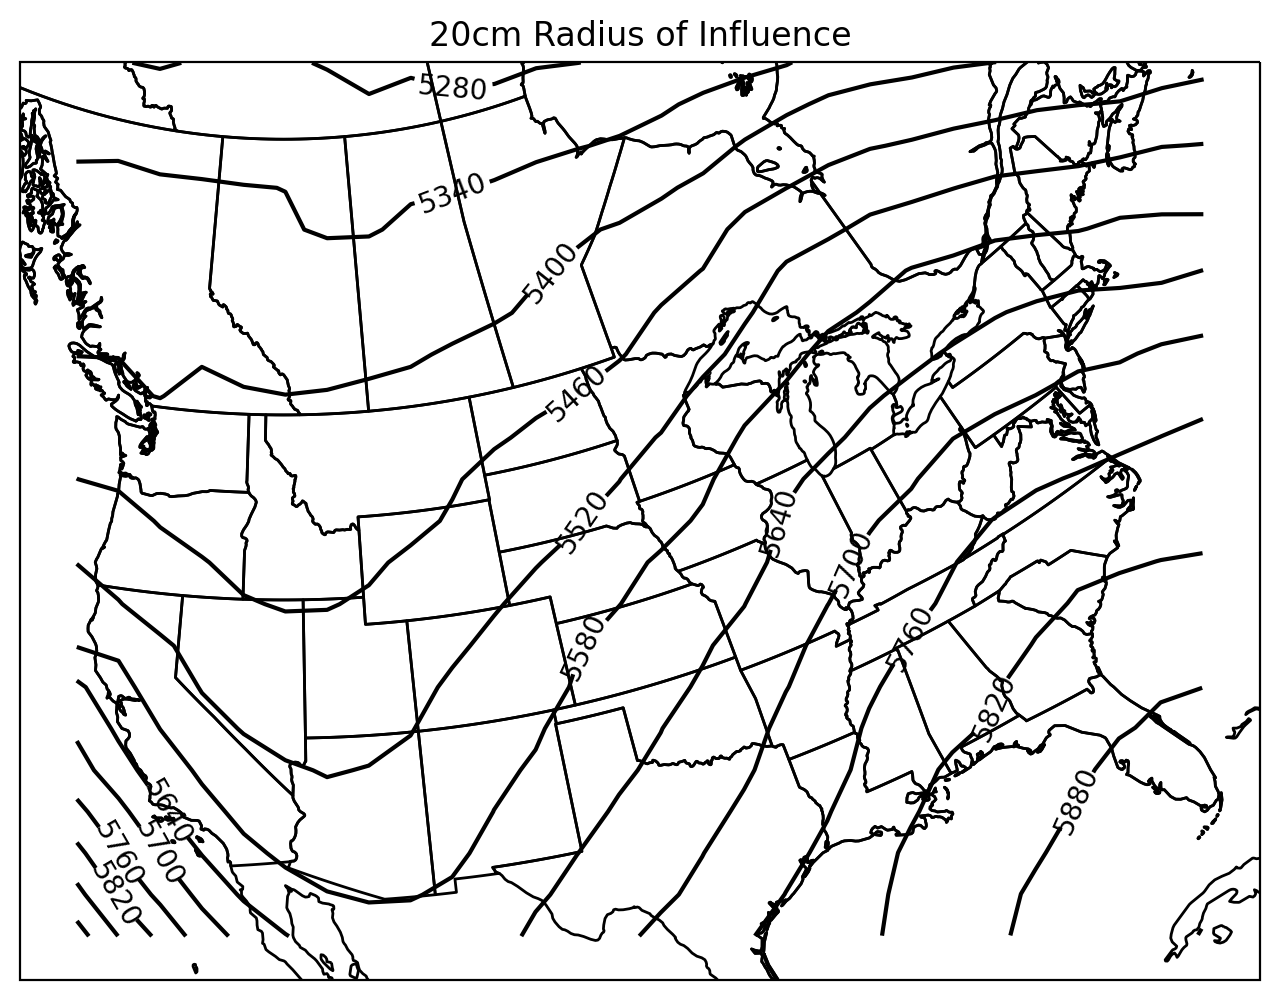

In [10]:
### Plot 500mb analyses over a map (20 cm ROI) ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(x2lon,y2lat,array_analysis[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('20cm Radius of Influence')
plt.savefig('20cm Radius of Influence')
plt.show()

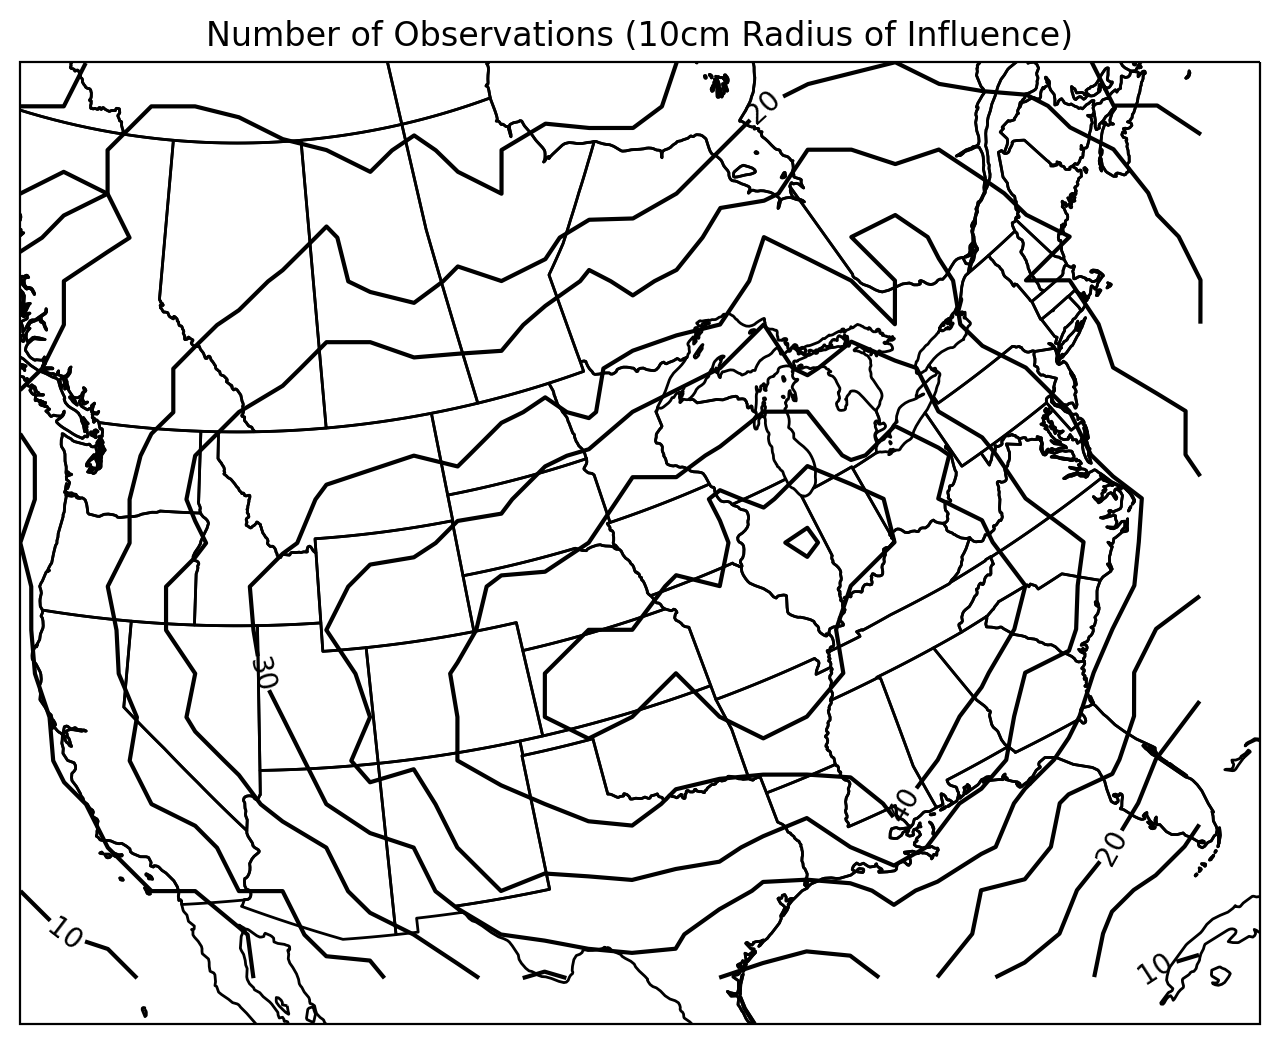

In [11]:
### Plot number of observations available to polynomial fitting scheme for each grid point (10 cm ROI) ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
plot10cm = ax1.contour(x2lon,y2lat,array_obs[:,:,0],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(plot10cm,levels=np.arange(0,200,10))
plt.title('Number of Observations (10cm Radius of Influence)')
plt.savefig('10cm Radius of Influence Number of Observations')
plt.show()

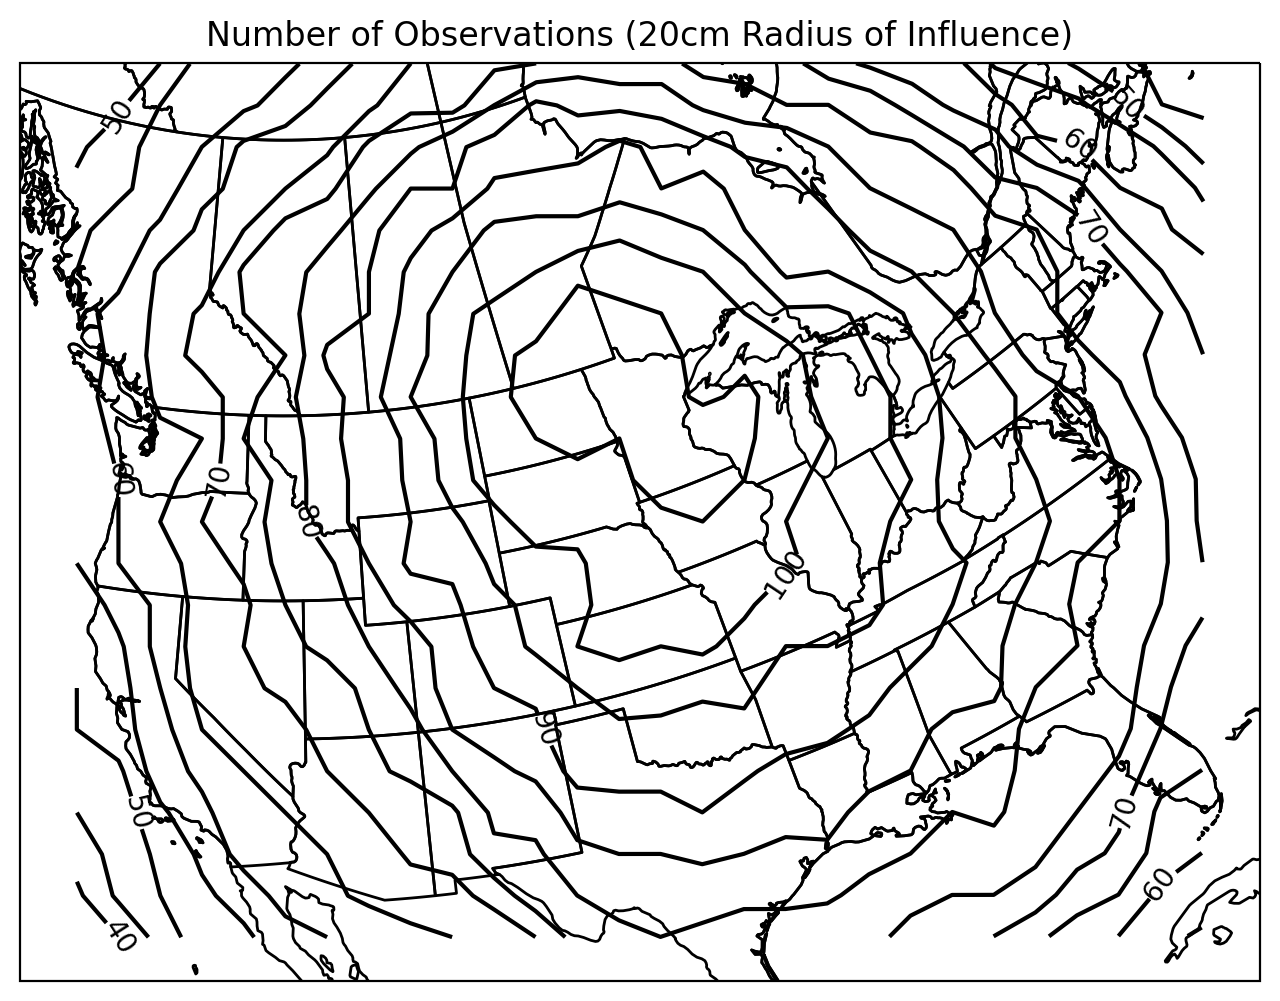

In [12]:
### Plot number of observations available to polynomial fitting scheme for each grid point (20 cm ROI) ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
plot20cm = ax1.contour(x2lon,y2lat,array_obs[:,:,1],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(plot20cm,levels=np.arange(0,200,10))
plt.title('Number of Observations (20cm Radius of Influence)')
plt.savefig('20cm Radius of Influence Number of Observations')
plt.show()

In [15]:
### Store the number of observations available for each grid point in text files ###
with open('ATSC528_FuncFit_roi_10_Kern.txt', 'a+') as f:
    f.write('grid_points, number_of_observations, analysis_values\n')
    for i in range(len(xx)):
        for j in range(len(xx[0])):
            grid_points = str([i,j])
            number_of_observations = str(array_obs[i,j,0])
            analysis_values = str(array_analysis[i,j,0])
            output_string = grid_points + ',' + number_of_observations + ','  + analysis_values +'\n'
            f.write(output_string)


In [16]:
### Store the number of observations available for each grid point in text files ###
with open('ATSC528_FuncFit_roi_20_Kern.txt', 'a+') as f:
    f.write('grid_points, number_of_observations, analysis_values\n')
    for i in range(len(xx)):
        for j in range(len(xx[0])):
            grid_points = str([i,j])
            number_of_observations = str(array_obs[i,j,1])
            analysis_values = str(array_analysis[i,j,1])
            output_string = grid_points + ','  + analysis_values + ',' + number_of_observations +'\n'
            f.write(output_string)


In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

We are seeing generally meridional flow with a large trough over the western U.S. and a ridge over the eastern U.S. 
Although some more weather analysis maps are needed to analyze, this flow looks sufficient for formation of a Colorado Low.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
The 10 cm analysis map shows the trough dig a lot deeper, and looks more intense. Whereas, the 20 cm analysis map 
does look a bit smoother than the 10 cm. Using a radius of influence of 20 cm may be too large and we are not able
to see features we want to analyze. The analysis points are being affected by a larger region of influence and smoothing
out features.


3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    
An error is displayed saying that it is a singular matrix. A singular matrix cannot be inverted and the determinant is 0.

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    
No, with only one observation, it would be a single matrix. The determinant would be zero and you cannot take the inverse.
    

'''